In [1]:
import os
import glob

import DESutils
import GPRutils
import vK2KGPR
import plotGPR
import vK2KGPR
import vonkarmanFT as vk

import numpy as np
import astropy.units as u
import astropy.table as tb
from astropy.time import Time
import matplotlib.pyplot as plt
plt.style.use('~/GitHub/custom-matplotlib/custom.mplstyle')
import astropy.stats as stats
from scipy.signal import savgol_filter

from IPython import embed
from importlib import reload
import warnings
warnings.filterwarnings("ignore")

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
# FITSfiles = sorted(glob.glob(f"/home/fortino/GPRSolutions/zone134/GPR.??????.?RC.fits"))
# FITSfiles += sorted(glob.glob(f"/home/fortino/GPRSolutions/zone133/GPR.??????.?RC.fits"))
# FITSfiles += sorted(glob.glob(f"/home/fortino/GPRSolutions/zone132/GPR.??????.?RC.fits"))
# FITSfiles += sorted(glob.glob(f"/home/fortino/GPRSolutions/eris/GPR.??????.?RC.fits"))
# print(len(FITSfiles))

FITSfiles = sorted(glob.glob(f"SampleSolutions/GPR.??????.?RC.fits"))
print(len(FITSfiles))

5


In [3]:
%%time
AP = plotGPR.AggregatePlots(FITSfiles)
AP.calcVals()

CPU times: user 2.79 s, sys: 170 ms, total: 2.96 s
Wall time: 2.98 s


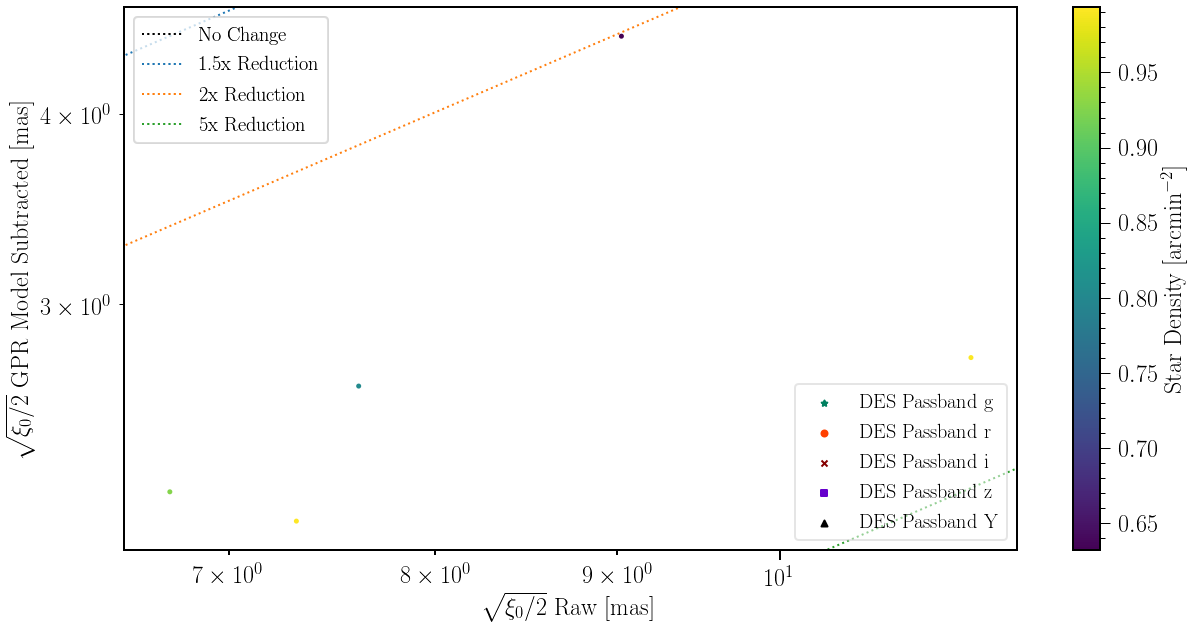

In [7]:
def xiBA2(
    AP,
    passband=None,
    annotate=True,
    save=None,
    xlim=(None, None),
    ylim=(None, None)
        ):
    framealpha = 0.5

    fig = plt.figure(figsize=(20, 10))
    plt.yscale("log")
    plt.xscale("log")

    bandHandles = []
    RMS_raw = []
    RMS_GPR = []
    RMSerr_raw = []
    RMSerr_GPR = []
    starDensity = []
    for band in plotGPR.DES_PASSBANDS:

        # Check if the current band in the loop is one of the bands in the list passband.
        if passband is not None:
            if band not in passband:
                continue

        # If there are no exposures for that band in AP, then skip it.
        if len(AP.expNums[band]) == 0:
            continue
        
        # Collect the raw and GPR RMS values
        RMS_raw.extend(AP.RMS_raw[band])
        RMS_GPR.extend(AP.RMS_GPR[band])

        # Collect the raw and GPR RMS error values
        RMSerr_raw.extend(AP.RMSerr_raw[band])
        RMSerr_GPR.extend(AP.RMSerr_GPR[band])
        
        # Collect the star densities
        starDensity.extend(u.Quantity(AP.starDensity[band]).value)
        
        # Sigma clip on the errors for the raw RMS
        maskraw = stats.sigma_clip(AP.RMSerr_raw[band], sigma=5).mask
#         print(np.array(AP.RMS_raw[band])[maskraw])
        avgRMS_raw = np.mean(np.array(AP.RMS_raw[band])[~maskraw])
        avgRMSErr_raw = np.sqrt(np.sum(np.power(np.array(AP.RMS_raw[band])[~maskraw], 2)))
        avgRMSErr_raw /= len(np.array(AP.RMS_raw[band])[~maskraw])
        
        # Sigma clip on the errors for the fitted RMS
        maskGPR_fC = stats.sigma_clip(AP.RMSerr_GPR_fC[band], sigma=5).mask
#         print(np.array(AP.RMS_GPR_fC[band])[maskGPR_fC])
        avgRMS_GPR_fC = np.mean(np.array(AP.RMS_GPR_fC[band])[~maskGPR_fC])
        avgRMSErr_GPR_fC = np.sqrt(np.sum(np.power(np.array(AP.RMS_GPR_fC[band])[~maskGPR_fC], 2)))
        avgRMSErr_GPR_fC /= len(np.array(AP.RMS_GPR_fC[band])[~maskGPR_fC])

        # Sigma clip on the errors for the GPR RMS
        maskGPR = stats.sigma_clip(AP.RMSerr_GPR[band], sigma=5).mask
#         print(np.array(AP.RMS_GPR[band])[maskGPR])
        avgRMS_GPR = np.mean(np.array(AP.RMS_GPR[band])[~maskGPR])
        avgRMSErr_GPR = np.sqrt(np.sum(np.power(np.array(AP.RMS_GPR[band])[~maskGPR], 2)))
        avgRMSErr_GPR /= len(np.array(AP.RMS_GPR[band])[~maskGPR])

        # Create the legend handle for the current band in the for loop. This scatter point is
        # arbitrary and is just used to put a label in the legend for the band.
        bandHandle = plt.scatter(
            -1, 0,
            alpha=1,
            color=plotGPR.DES_COLORS[band],
            marker=plotGPR.DES_MARKERS[band],
            label=f"DES Passband {band}"
#                   f"\nMean RMS (Raw): {avgRMS_raw:.3f} ± {avgRMSErr_raw:.3f} mas"
#                   f"\nMean RMS (Fit): {avgRMS_GPR_fC:.3f} ± {avgRMSErr_GPR_fC:.3f} mas"
#                   f"\nMean RMS (GPR): {avgRMS_GPR:.3f} ± {avgRMSErr_GPR:.3f} mas"
                )
        bandHandles.append(bandHandle)
        
        if annotate:
            for i in range(len(AP.expNums[band])):
                plt.annotate(
                    f"{AP.starDensity[band][i].value:.3f}",
                    (AP.RMS_raw[band][i], AP.RMS_GPR[band][i]),
                    fontsize=10)

    # Finally plot the RMS values for all bands at once. This way, the colors, given by kwarg c, are
    # all on the same cmap.
    scatter = plt.scatter(
        RMS_raw, RMS_GPR,
        c=starDensity, cmap="viridis",
        marker=".")

    # Add the handles for each band to the legend.
    bandLegend = plt.legend(
        handles=bandHandles,
        loc="lower right",
        framealpha=framealpha)
    plt.gca().add_artist(bandLegend)

    cbar = fig.colorbar(scatter, ax=plt.axes())
    cbar.set_label(r"Star Density [arcmin$^{-2}$]")

    plt.ylim(ylim)
    plt.xlim(xlim)

    x = np.linspace(0, 5000, 2)

    noChange = plt.plot(
        x, x,
        "k:",
        label="No Change")[0]

    red1_5 = plt.plot(
        x, x/1.5,
        c="tab:blue", ls=":",
        label="1.5x Reduction")[0]

    red2 = plt.plot(
        x, x/2,
        c="tab:orange",
        ls=":",
        label="2x Reduction")[0]
    
    red5 = plt.plot(
        x, x/5,
        c="tab:green", ls=":",
        label="5x Reduction")[0]

    refLegend = plt.legend(
        handles=[noChange, red1_5, red2, red5],
        loc="upper left",
        framealpha=framealpha)
    plt.gca().add_artist(refLegend)

    plt.xlabel(r"$\sqrt{\xi_{0}/2}$ Raw [mas]")
    plt.ylabel(r"$\sqrt{\xi_{0}/2}$ GPR Model Subtracted [mas]")

    if save is not None:
        plt.savefig(save)
    plt.show()
    
xiBA2(AP, ["g", "r", "i", "z", "Y"], annotate=False)
# xiBA2(AP, ["r", "i", "z"], annotate=False)